In [1]:
# 1. Install system-level dependencies (SWIG is the fix for your error)
!apt-get update && apt-get install -y swig python3-dev xvfb ffmpeg

# 2. Install Python libraries
!pip install gymnasium[box2d] stable-baselines3[extra] pyvirtualdisplay

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,858 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,411 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,564 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,598 kB]
Get:14 http:/

In [4]:
import gymnasium as gym
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# 1. Create log directory
log_dir = "./logs/ppo_tuned/"
os.makedirs(log_dir, exist_ok=True)

# 2. Setup Environment
def make_env():
    env = gym.make("BipedalWalker-v3")
    env = Monitor(env, log_dir) # This saves the 'monitor.csv' for plotting
    return env

# Vectorize and Normalize
env = DummyVecEnv([make_env])
norm_obs=True; norm_reward=True
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

In [5]:
from stable_baselines3 import PPO

# Tuned Hyperparameters for BipedalWalker
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    n_steps=2048,      # More steps before updating brain
    batch_size=128,     # Larger batch for stability
    n_epochs=10,
    gamma=0.99,
    learning_rate=3e-4,
    ent_coef=0.01,      # Forces more exploration (prevents "kneeling")
)

print("Training Tuned PPO...")
model.learn(total_timesteps=100000, progress_bar=True)

# Save both the model and the normalization stats (required for testing later)
model.save("ppo_bipedal_tuned")
env.save("vec_normalize.pkl")

Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: 
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects 
to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Training Tuned PPO...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 574      |
|    ep_rew_mean     | -107     |
| time/              |          |
|    fps             | 726      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 683         |
|    ep_rew_mean          | -108        |
| time/                   |             |
|    fps                  | 662         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008305541 |
|    clip_fraction        | 0.0655      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.69       |
|    explained_variance   | -0.0931     |
|    lea

In [8]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from gymnasium.wrappers import RecordVideo

# 1. Setup the Evaluation Environment
eval_env_id = "BipedalWalker-v3"
# Use a fresh env with render_mode for the video
temp_env = gym.make(eval_env_id, render_mode="rgb_array")
eval_env = DummyVecEnv([lambda: temp_env])

# 2. LOAD the Normalization stats from your training
# This is the "secret sauce" - without this, the model will fail!
eval_env = VecNormalize.load("vec_normalize.pkl", eval_env)
# Disable training mode for normalization (don't update stats during testing)
eval_env.training = False
eval_env.norm_reward = False

# 3. Wrap for Video
video_folder = "./eval_videos"
eval_env_video = RecordVideo(temp_env, video_folder=video_folder, name_prefix="tuned_walker")

# 4. Load Model and Run
model = PPO.load("ppo_bipedal_tuned")

obs, _ = eval_env_video.reset()
for _ in range(1000):
    # We must normalize the observation before giving it to the model
    norm_obs = eval_env.normalize_obs(obs)
    action, _ = model.predict(norm_obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env_video.step(action)
    if terminated or truncated:
        break

eval_env_video.close()

# Show the video (using the helper function we used earlier)
show_latest_video(video_folder)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Displaying: eval_videos/tuned_walker-episode-0.mp4


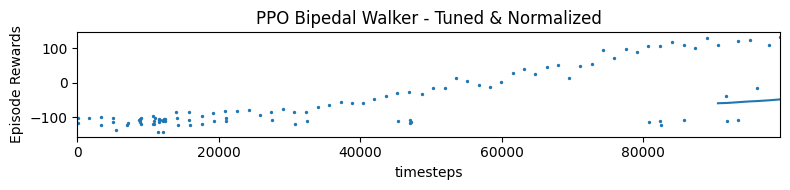

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:
import matplotlib.pyplot as plt
from stable_baselines3.common import results_plotter

# This function reads the log_dir and creates a smoothed reward graph
results_plotter.plot_results(
    [log_dir],
    100000,
    results_plotter.X_TIMESTEPS,
    "PPO Bipedal Walker - Tuned & Normalized"
)
plt.show()